In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '../DP/Data/glove.42B.300d.txt.zip'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import LSTM, GRU, Bidirectional

from sklearn.model_selection import train_test_split #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from keras.layers import Embedding, Dropout, Dense, LSTM, GRU


In [ ]:
dataset = pd.read_csv('../Data/final_dataset_2_balanced.csv')

## Split datasetu

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## One-hot encoding

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

## Embedding matica

In [ ]:
path_to_glove_file = 'glove.42B.300d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 1917494 word vectors.


In [ ]:
embeddings_index['happy'].shape

(300,)

In [ ]:
embedding_dim = 300
vocab_size = 60000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(X_train.values)

In [ ]:
voc = vect_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
voc[:10]

['', '[UNK]', 's', 'would', 'one', 'could', 'man', 'time', 'upon', 'said']

In [ ]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 51374 words (8626 misses)


# Modely

## Dense model

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.GlobalAveragePooling1D()(emb)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation='relu')(x)
output_layer =  keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 6000, 300)         18000600  
                                                                 
 global_average_pooling1d (  (None, 300)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 1024)              308224

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='glove_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
27/27 [==============================] - 215s 8s/step - loss: 2.9269 - accuracy: 0.0603 - val_loss: 2.8635 - val_accuracy: 0.1250
Epoch 2/15
27/27 [==============================] - 215s 8s/step - loss: 2.6046 - accuracy: 0.2355 - val_loss: 2.3560 - val_accuracy: 0.3958
Epoch 3/15
27/27 [==============================] - 199s 8s/step - loss: 2.0512 - accuracy: 0.4269 - val_loss: 1.8436 - val_accuracy: 0.5312
Epoch 4/15
27/27 [==============================] - 212s 8s/step - loss: 1.5690 - accuracy: 0.5592 - val_loss: 1.4992 - val_accuracy: 0.6354
Epoch 5/15
27/27 [==============================] - 205s 8s/step - loss: 1.2380 - accuracy: 0.6462 - val_loss: 1.2967 - val_accuracy: 0.6354
Epoch 6/15
27/27 [==============================] - 2s 91ms/step - loss: 1.0485 - accuracy: 0.6984 - val_loss: 1.3330 - val_accuracy: 0.6146
Epoch 7/15
27/27 [==============================] - 210s 8s/step - loss: 0.9816 - accuracy: 0.6984 - val_loss: 1.0675 - val_accuracy: 0.7292
Epoch 8/15
27

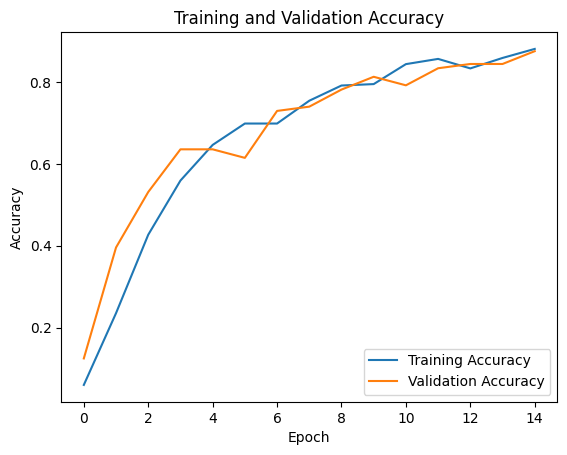

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 1s 76ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.8625
F1 Score: 0.8615857953374394
Precision: 0.8730189721269442
Recall: 0.8625


## CNN Model

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = tf.keras.layers.Conv1D(512, kernel_size=4, padding="valid", activation="relu")(emb)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 6000, 300)         18000600  
                                                                 
 conv1d (Conv1D)             (None, 5997, 512)         614912    
                                                                 
 max_pooling1d (MaxPooling1  (None, 2998, 512)         0         
 D)                                                              
                                                                 
 global_average_pooling1d_1  (None, 512)               0   

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='glove_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
27/27 [==============================] - 223s 8s/step - loss: 2.8626 - accuracy: 0.1183 - val_loss: 2.7496 - val_accuracy: 0.1354
Epoch 2/15
27/27 [==============================] - 209s 8s/step - loss: 2.3835 - accuracy: 0.2796 - val_loss: 2.2608 - val_accuracy: 0.3021
Epoch 3/15
27/27 [==============================] - 228s 9s/step - loss: 1.9492 - accuracy: 0.4130 - val_loss: 1.8478 - val_accuracy: 0.4479
Epoch 4/15
27/27 [==============================] - 220s 8s/step - loss: 1.5823 - accuracy: 0.5615 - val_loss: 1.5459 - val_accuracy: 0.6562
Epoch 5/15
27/27 [==============================] - 217s 8s/step - loss: 1.3883 - accuracy: 0.6148 - val_loss: 1.4499 - val_accuracy: 0.5833
Epoch 6/15
27/27 [==============================] - 226s 9s/step - loss: 1.2037 - accuracy: 0.6845 - val_loss: 1.2396 - val_accuracy: 0.6771
Epoch 7/15
27/27 [==============================] - 213s 8s/step - loss: 1.0199 - accuracy: 0.7390 - val_loss: 1.1375 - val_accuracy: 0.7708
Epoch 8/15
27

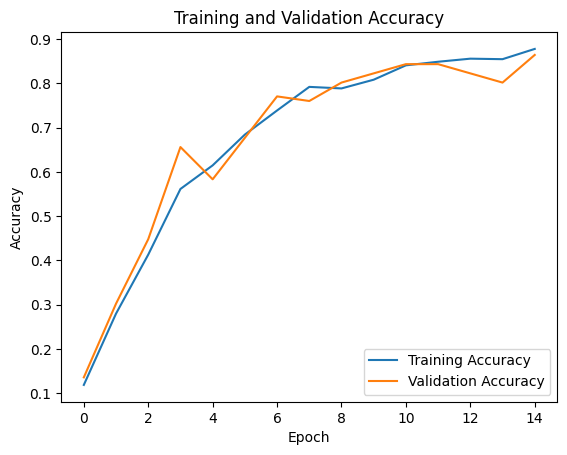

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 1s 98ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.8666666666666667
F1 Score: 0.8666113774715926
Precision: 0.8870402514152516
Recall: 0.8666666666666667


## Biderectional LSTMU

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(emb)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(256, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, 6000, 300)         18000600  
                                                                 
 bidirectional (Bidirection  (None, 6000, 256)         439296    
 al)                                                             
                                                                 
 global_average_pooling1d_2  (None, 256)               0         
  (GlobalAveragePooling1D)                                       
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='glove_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
27/27 [==============================] - 202s 7s/step - loss: 2.9605 - accuracy: 0.0626 - val_loss: 2.8850 - val_accuracy: 0.2083
Epoch 2/15
27/27 [==============================] - 213s 8s/step - loss: 2.6150 - accuracy: 0.2274 - val_loss: 2.4104 - val_accuracy: 0.2812
Epoch 3/15
27/27 [==============================] - 202s 8s/step - loss: 2.0871 - accuracy: 0.3376 - val_loss: 1.8801 - val_accuracy: 0.2917
Epoch 4/15
27/27 [==============================] - 196s 7s/step - loss: 1.6197 - accuracy: 0.4826 - val_loss: 1.5081 - val_accuracy: 0.5729
Epoch 5/15
27/27 [==============================] - 198s 8s/step - loss: 1.4139 - accuracy: 0.5278 - val_loss: 1.3096 - val_accuracy: 0.5938
Epoch 6/15
27/27 [==============================] - 208s 8s/step - loss: 1.2164 - accuracy: 0.5986 - val_loss: 1.2208 - val_accuracy: 0.6458
Epoch 7/15
27/27 [==============================] - 16s 547ms/step - loss: 1.0305 - accuracy: 0.6647 - val_loss: 1.2980 - val_accuracy: 0.6250
Epoch 8/15


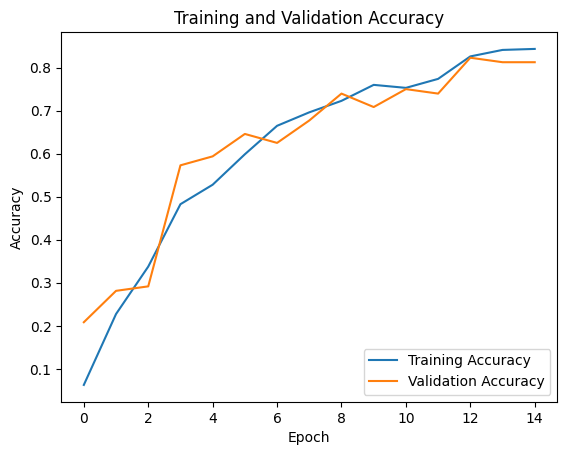

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 3s 224ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.8208333333333333
F1 Score: 0.8192689890727466
Precision: 0.8334234760337702
Recall: 0.8208333333333333


## LSTM + GRU

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.LSTM(256, return_sequences=True)(emb)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.GRU(128, return_sequences=False)(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.1)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)


model = keras.Model(input_layer, output_layer)
model.summary()


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, 6000, 300)         18000600  
                                                                 
 lstm_1 (LSTM)               (None, 6000, 256)         570368    
                                                                 
 dropout_5 (Dropout)         (None, 6000, 256)         0         
                                                                 
 gru (GRU)                   (None, 128)               148224    
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='glove_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
27/27 [==============================] - 218s 8s/step - loss: 2.9666 - accuracy: 0.0534 - val_loss: 2.9595 - val_accuracy: 0.1042
Epoch 2/15
27/27 [==============================] - 196s 7s/step - loss: 2.8851 - accuracy: 0.0754 - val_loss: 2.9413 - val_accuracy: 0.0625
Epoch 3/15
27/27 [==============================] - 211s 8s/step - loss: 2.7570 - accuracy: 0.1485 - val_loss: 2.8824 - val_accuracy: 0.0625
Epoch 4/15
27/27 [==============================] - 209s 8s/step - loss: 2.5754 - accuracy: 0.1949 - val_loss: 2.8693 - val_accuracy: 0.0833
Epoch 5/15
27/27 [==============================] - 204s 8s/step - loss: 2.3620 - accuracy: 0.2564 - val_loss: 2.8141 - val_accuracy: 0.0833
Epoch 6/15
27/27 [==============================] - 16s 570ms/step - loss: 2.1335 - accuracy: 0.3353 - val_loss: 2.9929 - val_accuracy: 0.1146
Epoch 7/15
27/27 [==============================] - 15s 573ms/step - loss: 1.9014 - accuracy: 0.3944 - val_loss: 3.1408 - val_accuracy: 0.1354
Epoch 8/1

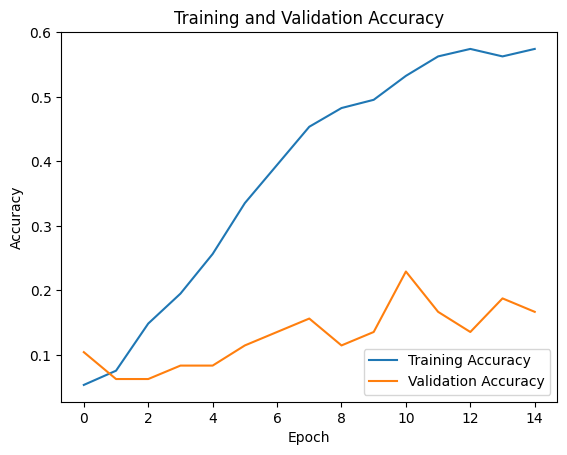

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 3s 254ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.13333333333333333
F1 Score: 0.11949105242059567
Precision: 0.18252591706539073
Recall: 0.13333333333333333
